## Focus on the non-voter who are intend-to-vote

- ratio of intend-to-vote but finally no-voter
- per year analysis over ratio across years
- group-analysis on features effect on the intent-vote group arcoss races



In [1]:
import pandas as pd
import numpy as np
import utils
# import model
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import matplotlib.pyplot as plt


# data path
file_path = '../data/cumulative_2022_v3_9_domain.csv'

data = pd.read_csv(file_path)

column_to_variable_dict = np.load('../data/column_to_variable_dict.npy', allow_pickle=True).item()
variable_to_column_dict = np.load('../data/variable_to_column_dict.npy', allow_pickle=True).item()

value_label_dict = np.load('../data/value_labels.npy', allow_pickle=True).item()

# check the "Year" column's max and min value
print(data['Year'].max())
print(data['Year'].min())

2020.0
1948.0


In [2]:
target_variable = 'Voted'

'''Voted  {0.0: '0. DK; NA; no Post IW; refused to say if voted;', 1.0: '1. No, did not vote', 2.0: '2. Yes, voted'}'''

# filter out the samples with missing value of the target variable,drop the index
data_new = data[data[target_variable].notnull()]
# filter out the samples with target variable value = 0, count the number of samples whose target variable value = 0, 1 or 2

print('number of samples who not vote : ', len(data_new[data_new[target_variable] == 1]))
print('number of samples who vote : ', len(data_new[data_new[target_variable] == 2]))
print('number of samples who vote case DK : ', len(data_new[data_new[target_variable] == 0]))

sub_target_variable = 'Pre_election_inten_vote'

'''Pre_election_inten_vote  {0.0: '0. DK (1964 only); NA; no Pre IW; DK/NA/RF (1952', 1.0: '1. Democratic candidate (with or without qualifications,', 2.0: '2. Republican candidate (with or without qualifications,', 3.0: '3. Undecided; DK (except 1964)', 4.0: "4. R does not intend to vote (incl. 'no, qualified' if", 9.0: '9. Other candidate'}
'''
#  count the number of samples whose sub target variable value = 0, 1, 2, 3, 4, 9, and with missing value
print('\n\n number of samples who not intend vote : ', len(data_new[data_new[sub_target_variable] == 4]))

print('number of samples who intend vote for Democratic candidate : ', len(data_new[data_new[sub_target_variable] == 1]))

print('number of samples who intend vote for Republican candidate : ', len(data_new[data_new[sub_target_variable] == 2]))

print('number of samples who undecided : ', len(data_new[data_new[sub_target_variable] == 3]))

print('number of samples who intend vote for other candidate : ', len(data_new[data_new[sub_target_variable] == 9]))

print('number of samples who intend vote case DK : ', len(data_new[data_new[sub_target_variable] == 0]))

print('number of samples who intend vote with missing value : ', len(data_new[data_new[sub_target_variable].isnull()]))

# chekc the year's distribution for who has no missing value of the "intend vote" variable

# print(data_new[data_new[sub_target_variable].notnull()]['Year'].value_counts())
# len(data_new[data_new[sub_target_variable].notnull()])

number of samples who not vote :  17790
number of samples who vote :  44188
number of samples who vote case DK :  0


 number of samples who not intend vote :  4879
number of samples who intend vote for Democratic candidate :  16538
number of samples who intend vote for Republican candidate :  14549
number of samples who undecided :  1892
number of samples who intend vote for other candidate :  1442
number of samples who intend vote case DK :  0
number of samples who intend vote with missing value :  22678


In [3]:


def stat_ratio(group,group_name=None, print_flag=False):

    # compute the length and the raios of voter/non-voter, vote_D, vote_R

    ratio_dict = {}

    if group_name is not None:

        ratio_dict['name']=group_name
    group_size =   len(group)
    # print(group_size)
    voter_size = len(group[group['Voted'] == 2])

    intent_to_vote_size = len(group[(group['Pre_election_inten_vote'] == 1) | (group['Pre_election_inten_vote'] == 2)])

    intent_not_to_vote_size = len(group[group['Pre_election_inten_vote'] == 4])

    has_intent_feature_size = len(group[group['Pre_election_inten_vote'].notnull()])

    intent_to_vote_final_non_voter_size = len(group[(group['Pre_election_inten_vote'] == 1) & (group['Voted'] == 1)]) + len(group[(group['Pre_election_inten_vote'] == 2) & (group['Voted'] == 1)])

    intent_to_vote_R_final_non_voter_size = len(group[(group['Pre_election_inten_vote'] == 2) & (group['Voted'] == 1)])

    intent_to_vote_D_final_non_voter_size = len(group[(group['Pre_election_inten_vote'] == 1) & (group['Voted'] == 1)])

    real_voter_D_R_size = len(group[group['Voted_party'] == 1.0]) + len(group[group['Voted_party'] == 2.0])

    ratio_dict['voter_ratio'] = voter_size/group_size
    ratio_dict['non_voter_ratio'] = len(group[group['Voted'] == 1])/group_size
    ratio_dict['vote_D_ratio'] = len(group[group['Voted_party'] == 1.0])/real_voter_D_R_size
    ratio_dict['vote_R_ratio'] = len(group[group['Voted_party'] == 2.0])/real_voter_D_R_size


    ratio_dict['intent_to_vote_ratio'] = intent_to_vote_size/has_intent_feature_size
    ratio_dict['intent_not_to_vote_ratio'] = intent_not_to_vote_size/has_intent_feature_size

    ratio_dict['intent_to_vote_final_non_voter_ratio'] = intent_to_vote_final_non_voter_size/intent_to_vote_size
    ratio_dict['intent_to_vote_R_final_non_voter_ratio'] = intent_to_vote_R_final_non_voter_size/intent_to_vote_size

    ratio_dict['intent_to_vote_D_final_non_voter_ratio'] = intent_to_vote_D_final_non_voter_size/intent_to_vote_size


    ratio_dict['group_size'] = group_size
    ratio_dict['voter_size'] = voter_size
    ratio_dict['non_voter_size'] =  len(group[group['Voted'] == 1])
    ratio_dict['vote_D_size'] = len(group[group['Voted_party'] == 1.0])
    ratio_dict['vote_R_size'] = len(group[group['Voted_party'] == 2.0])
    ratio_dict['real_voter_D_R_size'] = real_voter_D_R_size

    ratio_dict['intent_to_vote_size'] = intent_to_vote_size
    ratio_dict['intent_not_to_vote_size'] = intent_not_to_vote_size
    ratio_dict['has_intent_feature_size'] = has_intent_feature_size
    ratio_dict['intent_to_vote_final_non_voter_size'] = intent_to_vote_final_non_voter_size
    ratio_dict['intent_to_vote_R_final_non_voter_size'] = intent_to_vote_R_final_non_voter_size
    ratio_dict['intent_to_vote_D_final_non_voter_size'] = intent_to_vote_D_final_non_voter_size

    if print_flag:
        print(ratio_dict)


    return ratio_dict

def stat_ratio_by_period(group,period_list=[(1948,2020)],group_name=None):
    
    # compute the stat_ratio by cummulative years
    """problem: some group size are zero"""

    result_dict = {}
    result_dict['name']=group_name
    result_dict['total_stat'] =  stat_ratio(group,group_name)
    print(result_dict['total_stat'])

    result_dict['period_stat'] = []
    # period_list = [(1983,2011),(2012,2020)]

    for period in period_list:
        start_year = period[0]
        end_year = period[1]
        sub_group = group[(group['Year'] <= end_year) & (group['Year'] >=start_year)]
        result_dict['period_stat'].append(stat_ratio(sub_group,group_name))
    return result_dict


def urban_rural_analysis(group,group_name):
    # urban_rural_analysis
    with_urbanism_group = group[group['urbanism'].notnull()]
    no_urbanism_group = group[group['urbanism'].isnull()]

    urban_group = group[group['urbanism']==1]
    suburban_group = group[group['urbanism']==2]
    rural_group = group[group['urbanism']==3]

    result_dict = {}
    result_dict['name']=group_name+'_urban_rural'
    result_dict['total'] =  stat_ratio(group,group_name,print_flag=True)
    result_dict['with_urbanism'] =  stat_ratio(urban_group,group_name+'_with_urbanism')
    result_dict['no_urbanism'] =  stat_ratio(no_urbanism_group,group_name+'_no_urbanism')
    result_dict['urban'] =  stat_ratio(urban_group,group_name+'_urban',print_flag=True)
    result_dict['suburban'] =  stat_ratio(suburban_group,group_name+'_suburban',print_flag=True)
    result_dict['rural'] =  stat_ratio(rural_group,group_name+'_rural',print_flag=True)

    return result_dict


In [4]:
def make_result_table(result_dict, target_var, target_group = ['total', 'urban', 'suburban', 'rural'], save_path = None):
    """based on the result_dict, make the result table
   the result table is dataframe, each row is a group('total, urban, suburban, rural) , each column is a target variable, the value is the extracted based on the target variable and the group name
    """

    group_name = result_dict['name'].split('_')[0]
    # make the column: name + targets
    table = pd.DataFrame(columns=['Group']+ target_var)
    
    # make the the first column: group name + ['total, urban, suburban, rural]
    table['Group'] = [group_name+'_'+ it for it in target_group]

    # make the value of the table, 

    for var in target_var:
        # table[var] = [result_dict[it][var].round(3) for it in target_group]
        table[var] = [result_dict[it][var] for it in target_group]

    # only keep ".3%float" for the ratio
    for var in target_var:
        if 'ratio' in var:
            table[var] = table[var].apply(lambda x: format(x, '.2%'))

    if save_path is not None:
            # check path exist, otherwise make the dir
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        table.to_csv(save_path+result_dict['name']+'.csv', index=False)
    
    return table
    

In [5]:
result_dict_black = urban_rural_analysis(data_new[data_new['Race7'] == 2],group_name='black')
print('\n')
result_dict_white = urban_rural_analysis(data_new[data_new['Race7'] == 1],group_name='white')


{'name': 'black', 'voter_ratio': 0.6525862068965518, 'non_voter_ratio': 0.3474137931034483, 'vote_D_ratio': 0.9440188568061285, 'vote_R_ratio': 0.05598114319387154, 'intent_to_vote_ratio': 0.7907903475758247, 'intent_not_to_vote_ratio': 0.14677883551029444, 'intent_to_vote_final_non_voter_ratio': 0.1534154535274356, 'intent_to_vote_R_final_non_voter_ratio': 0.01959686450167973, 'intent_to_vote_D_final_non_voter_ratio': 0.13381858902575589, 'group_size': 6960, 'voter_size': 4542, 'non_voter_size': 2418, 'vote_D_size': 3204, 'vote_R_size': 190, 'real_voter_D_R_size': 3394, 'intent_to_vote_size': 3572, 'intent_not_to_vote_size': 663, 'has_intent_feature_size': 4517, 'intent_to_vote_final_non_voter_size': 548, 'intent_to_vote_R_final_non_voter_size': 70, 'intent_to_vote_D_final_non_voter_size': 478}
{'name': 'black_urban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio'

In [30]:
target_var = ['has_intent_feature_size','intent_to_vote_ratio',  'intent_to_vote_final_non_voter_ratio', 'intent_to_vote_R_final_non_voter_ratio', 'intent_to_vote_D_final_non_voter_ratio']

save_path = '../result/non_voter_analysis/group_table/'

table_white = make_result_table(result_dict_white, target_var = target_var, save_path=save_path)
table_black = make_result_table(result_dict_black, target_var = target_var,save_path=save_path )

In [31]:
target_var = ['group_size','voter_ratio', 'vote_D_ratio', 'vote_R_ratio' ]

save_path = '../result/voter_analysis/group_table/'

table_white = make_result_table(result_dict_white, target_var = target_var, save_path=save_path)
table_black = make_result_table(result_dict_black, target_var = target_var,save_path=save_path )

In [46]:
table_black

,Group,has_intent_feature_size,voter_ratio,intent_to_vote_ratio,intent_not_to_vote_ratio,intent_to_vote_final_non_voter_ratio,intent_to_vote_R_final_non_voter_ratio,intent_to_vote_D_final_non_voter_ratio
0,black_total,4517,65.26%,79.08%,14.68%,15.34%,1.96%,13.38%
1,black_urban,1095,60.26%,73.15%,20.82%,14.98%,1.62%,13.36%
2,black_suburban,398,52.96%,66.83%,23.87%,20.68%,3.01%,17.67%
3,black_rural,579,43.31%,58.89%,31.61%,29.91%,6.74%,23.17%


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# group =data_new[data_new['Race7'] == 1]

# with_urbanism_group = group[group['urbanism'].notnull()]

# with_urbanism_group['Year'].value_counts().sort_index().plot(kind='bar',title='white with urbanism feature')

# urban_group = group[group['urbanism']==1]
# suburban_group = group[group['urbanism']==2]
# rural_group = group[group['urbanism']==3]

# period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]
period_list = [(i,i) for i in range(1948,2002)]


# urban_group_period_dict =  stat_ratio_by_period(urban_group,period_list,group_name='white_urban')
# suburban_group_period_dict =  stat_ratio_by_period(suburban_group,period_list,group_name='white_suburban')
# rural_group_period_dict =  stat_ratio_by_period(rural_group,period_list,group_name='white_rural')

def extract_period_ratio(result_dict, ratio_name):
    result = []
    for period_dict in result_dict['period_stat']:
        result.append(period_dict[ratio_name])
    return np.array(result)

# extract_period_ratio(urban_group_period_dict, 'voter_ratio')

# plot the voter ratio by period across different urbanism

def plot_period_rural_urban(group, group_name='white', ratio_name='voter_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)], save_path = None, year_gap=10):

    urban_group = group[group['urbanism']==1]
    suburban_group = group[group['urbanism']==2]
    rural_group = group[group['urbanism']==3]

    # period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]

    urban_group_period_dict =  stat_ratio_by_period(urban_group ,period_list, group_name+'urban')
    suburban_group_period_dict =  stat_ratio_by_period(suburban_group,period_list,group_name+'suburban')
    rural_group_period_dict =  stat_ratio_by_period(rural_group,period_list,group_name+'rural')

    # period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]
    period_list_str = [str(item[0])+'-\n'+str(item[1]) for item in period_list]

    urban_voter_ratio = extract_period_ratio(urban_group_period_dict, ratio_name)
    suburban_voter_ratio = extract_period_ratio(suburban_group_period_dict,ratio_name)
    rural_voter_ratio = extract_period_ratio(rural_group_period_dict,ratio_name)


    plt.plot(period_list_str,urban_voter_ratio, label='urban', marker='o')
    plt.plot(period_list_str,suburban_voter_ratio, label='suburban', marker='*')
    plt.plot(period_list_str,rural_voter_ratio, label='rural', marker='x')
    plt.legend()

    plt.title( ratio_name +'_of_'+ group_name  + '_by period across urbanism')
    plt.ylabel(ratio_name)
    plt.xlabel('period')
    # set sticy xticks size
    plt.xticks(rotation=30, fontsize=8)
    

    if save_path is not None:
        # check path exist, otherwise make the dir
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # make a dataframe to save the result
        result = pd.DataFrame()
        result['period'] = period_list_str
        result[group_name + '_urban'] = pd.Series(urban_voter_ratio).apply(lambda x: format(x, '.2%'))
        result[group_name + '_suburban'] = pd.Series(suburban_voter_ratio).apply(lambda x: format(x, '.2%'))
        result[group_name + '_rural'] = pd.Series(rural_voter_ratio).apply(lambda x: format(x, '.2%'))

        result.to_csv(save_path+str(year_gap)+'-year-'+group_name+'_'+ratio_name+'.csv', index=False)
        # also save the  figure
        plt.savefig(save_path+str(year_gap)+'-year-'+group_name+'_'+ratio_name+'.png')

    plt.show()
    plt.close()
        

def plot_period_races(group, group_name='', ratio_name='voter_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)], save_path = None):

    white_group = group[group['Race7'] == 1]
    black_group = group[group['Race7'] == 2]
    hispanic_group = group[group['Race7'] == 5]
    
    white_group_period_dict =  stat_ratio_by_period(white_group ,period_list, group_name+'white')
    black_group_period_dict =  stat_ratio_by_period(black_group,period_list,group_name+'black')
    # hispanic_group_period_dict =  stat_ratio_by_period(hispanic_group,period_list,group_name+'hispanic')

    period_list_str = [str(item[0])+'-\n'+str(item[1]) for item in period_list]



    white_voter_ratio = extract_period_ratio(white_group_period_dict, ratio_name)
    black_voter_ratio = extract_period_ratio(black_group_period_dict,ratio_name)
    # hispanic_voter_ratio = extract_period_ratio(hispanic_group_period_dict,ratio_name)

    plt.plot(period_list_str,white_voter_ratio, label='white', marker='o')
    plt.plot(period_list_str,black_voter_ratio, label='black', marker='*')
    # plt.plot(period_list_str,hispanic_voter_ratio, label='hispanic', marker='x')

    # plt.plot(period_list_str,urban_voter_ratio, label='urban', marker='o')
    # plt.plot(period_list_str,suburban_voter_ratio, label='suburban', marker='*')
    # plt.plot(period_list_str,rural_voter_ratio, label='rural', marker='x')
    plt.legend()

    plt.title( ratio_name  + '_by period across different races')
    plt.ylabel(ratio_name)
    plt.xlabel('period')
    # set sticy xticks size
    plt.xticks(rotation=30, fontsize=8)
    

    if save_path is not None:
        # check path exist, otherwise make the dir
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # make a dataframe to save the result
        result = pd.DataFrame()
        result['period'] = period_list_str
        result[group_name + '_white'] = pd.Series(white_voter_ratio).apply(lambda x: format(x, '.2%'))
        result[group_name + '_black'] = pd.Series(black_voter_ratio).apply(lambda x: format(x, '.2%'))
        # result[group_name + '_hispanic'] = pd.Series(hispanic_voter_ratio).apply(lambda x: format(x, '.2%'))

        result.to_csv(save_path+group_name+'_'+ratio_name+'.csv', index=False)

        # also save the  figure
        plt.savefig(save_path+group_name+'_'+ratio_name+'.png')
    plt.show()
    plt.close()
        


In [ ]:

year_gap = 4
period_list = [(i,i+year_gap-1) for i in range(1950,2022,year_gap)]


save_path = '../result/non_voter_analysis/period_analysis/'
group_name= str(year_gap)+ '-year-'+ 'black+white'

plot_period_races(
    data_new, 
group_name=group_name, 
ratio_name='intent_to_vote_final_non_voter_ratio', 
period_list = period_list,
save_path = save_path)

plot_period_races(
    data_new,
group_name=group_name,
ratio_name='intent_to_vote_R_final_non_voter_ratio',
period_list = period_list,
save_path = save_path)

plot_period_races(
    data_new,
group_name=group_name,
ratio_name='intent_to_vote_D_final_non_voter_ratio',
period_list = period_list,
save_path = save_path)

# plot_period_races(data_new, ratio_name='intent_to_vote_R_final_non_voter_ratio', period_list = period_list)
# plot_period_races(data_new, ratio_name='intent_to_vote_D_final_non_voter_ratio', period_list = period_list)

# plot_period_races(data_new, ratio_name='voter_ratio', period_list = period_list)
# plot_period_races(data_new, ratio_name='vote_D_ratio', period_list = period_list)
# plot_period_races(data_new, ratio_name='vote_R_ratio', period_list = period_list)



In [ ]:
year_gap = 4
period_list = [(i,i+year_gap-1) for i in range(1950,2022,year_gap)]

save_path = '../result/voter_analysis/period_analysis/'
group_name= str(year_gap)+ '-year-'+ 'black+white'

plot_period_races(
    data_new, 
group_name=group_name, 
ratio_name='voter_ratio', 
period_list = period_list,
save_path = save_path)

plot_period_races(
    data_new,
group_name=group_name,
ratio_name='vote_D_ratio',
period_list = period_list,
save_path = save_path)

plot_period_races(
    data_new,
group_name=group_name,
ratio_name='vote_R_ratio',
period_list = period_list,
save_path = save_path)

In [ ]:
year_gap = 4
period_list = [(i,i+year_gap-1) for i in range(1950,2002,year_gap)]
# plot_period_races(data_new, ratio_name='voter_ratio', period_list = period_list)
# plot_period_races(data_new, ratio_name='vote_D_ratio', period_list = period_list)
# plot_period_races(data_new, ratio_name='vote_R_ratio', period_list = period_list)

save_path = '../result/non_voter_analysis/period_analysis_rural_urban/'

plot_period_rural_urban(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='intent_to_vote_final_non_voter_ratio', 
period_list = period_list,
save_path = save_path, 
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='intent_to_vote_D_final_non_voter_ratio',
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='intent_to_vote_R_final_non_voter_ratio',
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='intent_to_vote_final_non_voter_ratio',
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='intent_to_vote_D_final_non_voter_ratio',
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='intent_to_vote_R_final_non_voter_ratio',
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)



{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

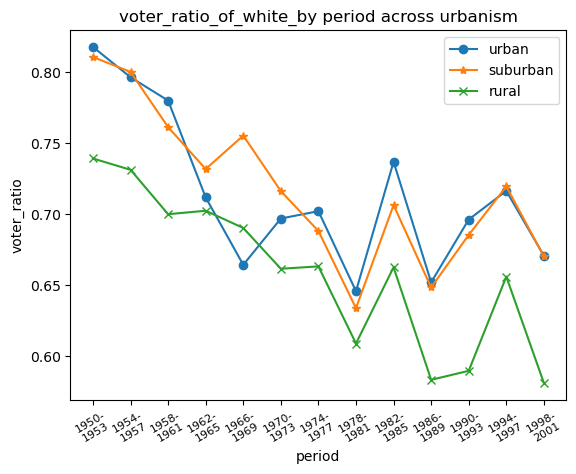

{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

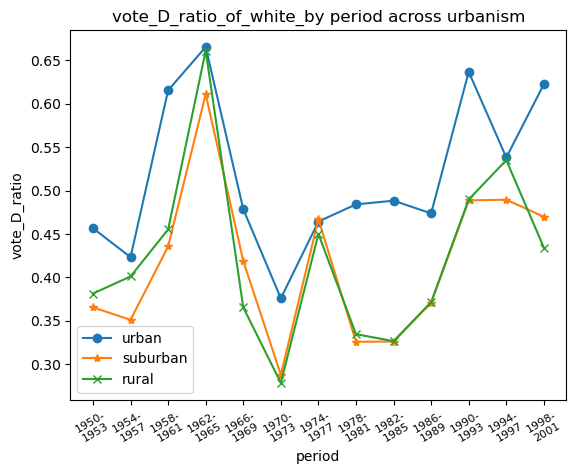

{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

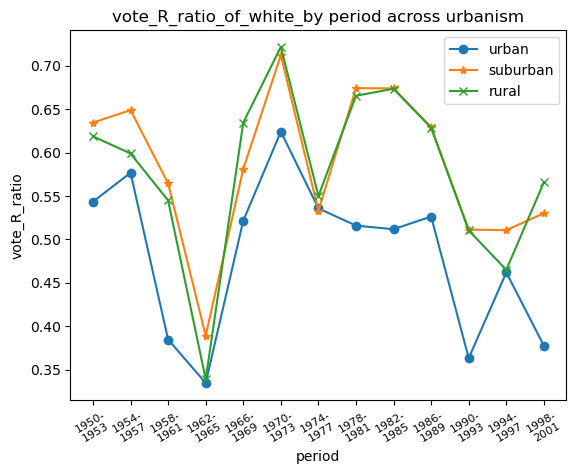

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

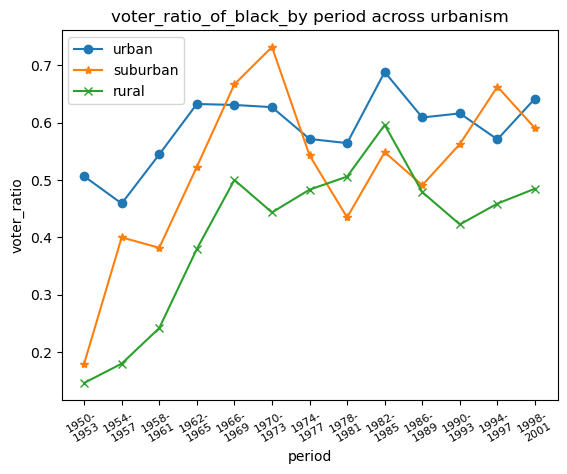

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

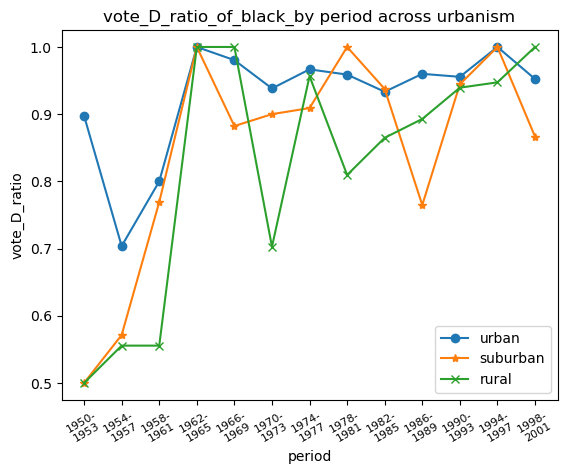

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

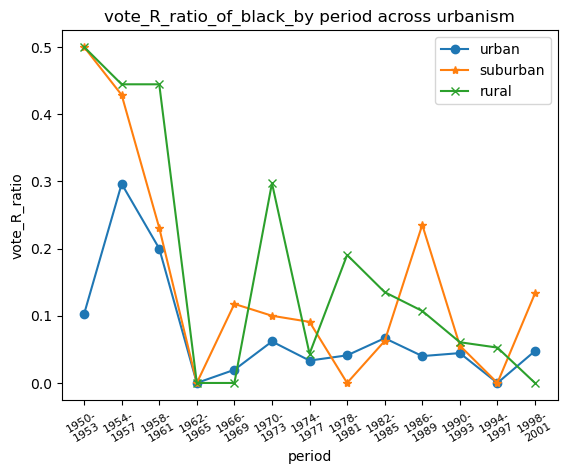

In [34]:
year_gap = 4
period_list = [(i,i+year_gap-1) for i in range(1950,2002,year_gap)]
# plot_period_races(data_new, ratio_name='voter_ratio', period_list = period_list)
# plot_period_races(data_new, ratio_name='vote_D_ratio', period_list = period_list)
# plot_period_races(data_new, ratio_name='vote_R_ratio', period_list = period_list)

save_path = '../result/voter_analysis/period_analysis_rural_urban/'

plot_period_rural_urban(data_new[data_new['Race7'] == 1], group_name='white', 
ratio_name='voter_ratio', 
period_list = period_list,
save_path = save_path, 
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 1], group_name='white', 
ratio_name='vote_D_ratio',
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 1], group_name='white',
 ratio_name='vote_R_ratio',
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 2], group_name='black', 
ratio_name='voter_ratio', 
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 2], group_name='black',
 ratio_name='vote_D_ratio', 
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)

plot_period_rural_urban(data_new[data_new['Race7'] == 2], group_name='black',  
ratio_name='vote_R_ratio', 
period_list = period_list,
save_path = save_path,
year_gap=year_gap,
)



{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

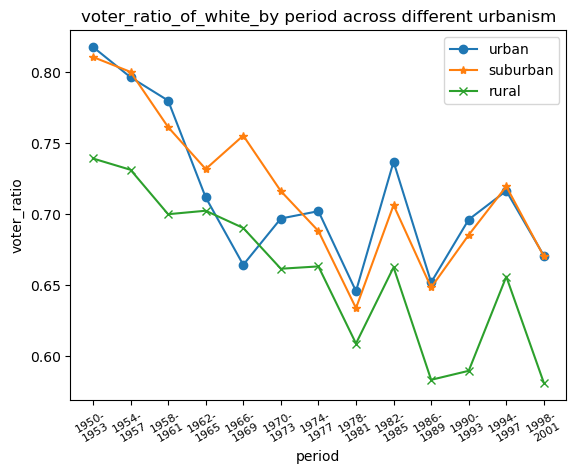

{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

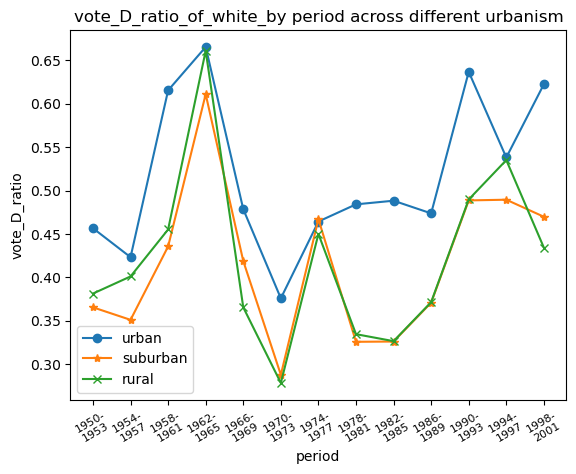

{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

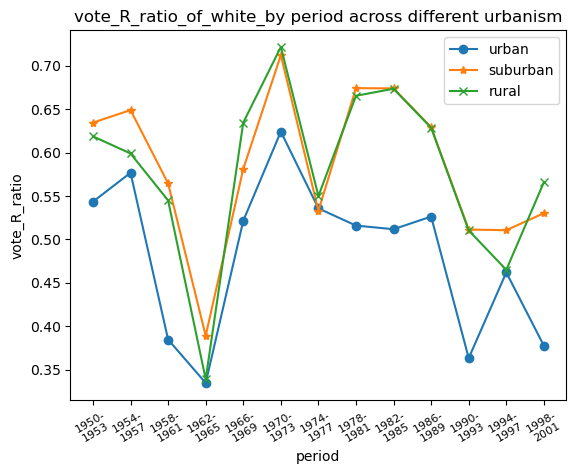

{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

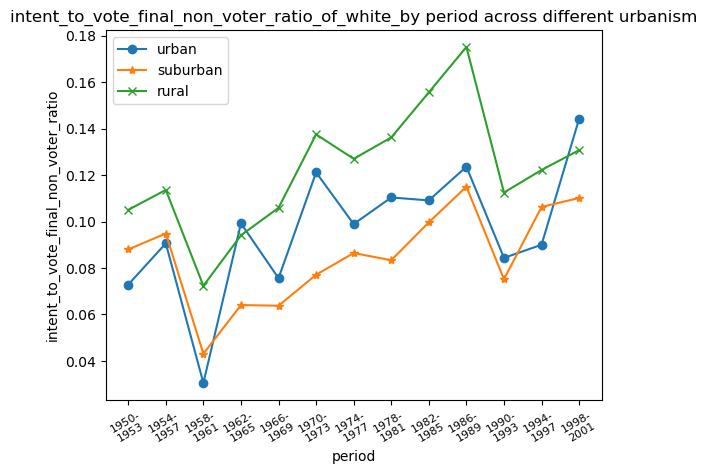

{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

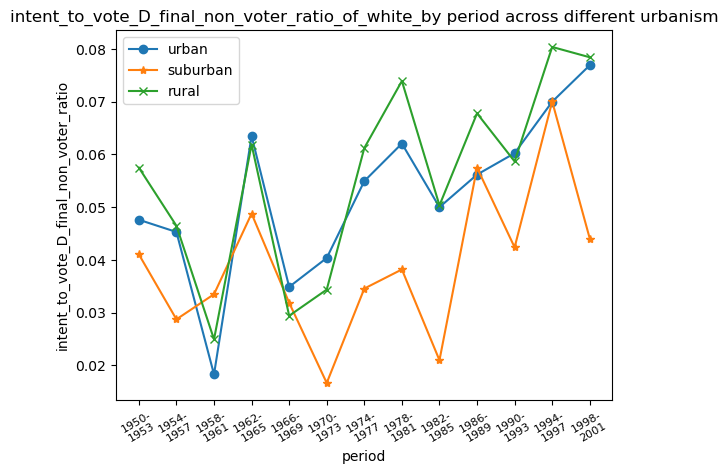

{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'intent_to_vote_ratio': 0.7690081557484872, 'intent_not_to_vote_ratio': 0.13627992633517497, 'intent_to_vote_final_non_voter_ratio': 0.09476565172767705, 'intent_to_vote_R_final_non_voter_ratio': 0.04344851180294218, 'intent_to_vote_D_final_non_voter_ratio': 0.05131713992473486, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918, 'intent_to_vote_size': 2923, 'intent_not_to_vote_size': 518, 'has_intent_feature_size': 3801, 'intent_to_vote_final_non_voter_size': 277, 'intent_to_vote_R_final_non_voter_size': 127, 'intent_to_vote_D_final_non_voter_size': 150}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'intent_to_v

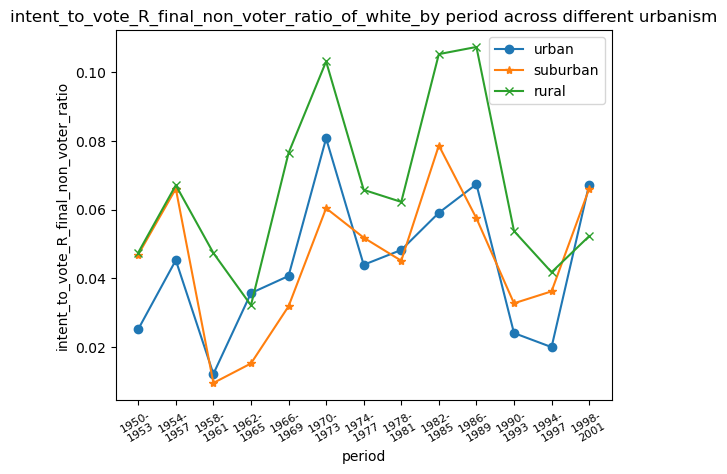

In [100]:
period_list = [(i,i+3) for i in range(1950,2002,4)]
# period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]

plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='voter_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='vote_D_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='vote_R_ratio', period_list = period_list)

plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='intent_to_vote_final_non_voter_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='intent_to_vote_D_final_non_voter_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='intent_to_vote_R_final_non_voter_ratio', period_list = period_list)







{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

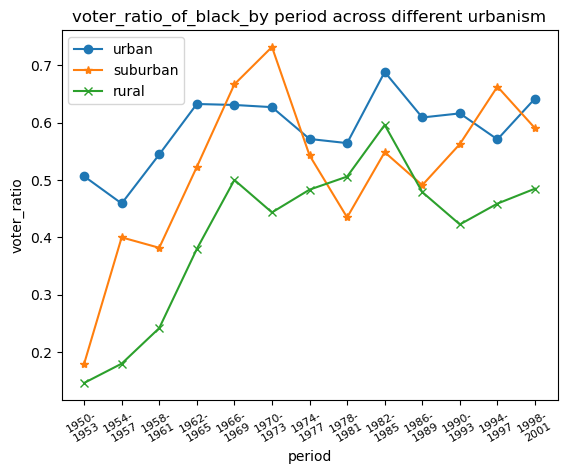

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

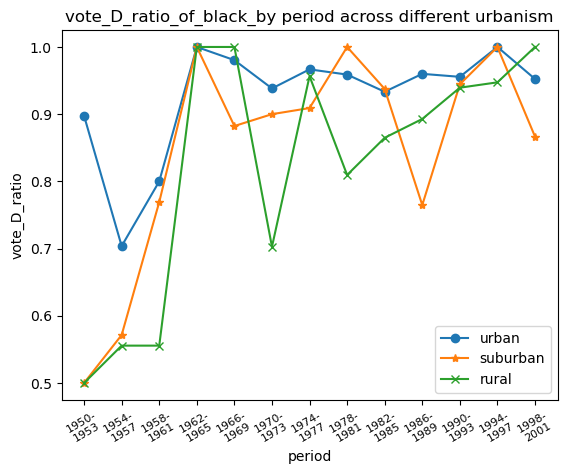

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

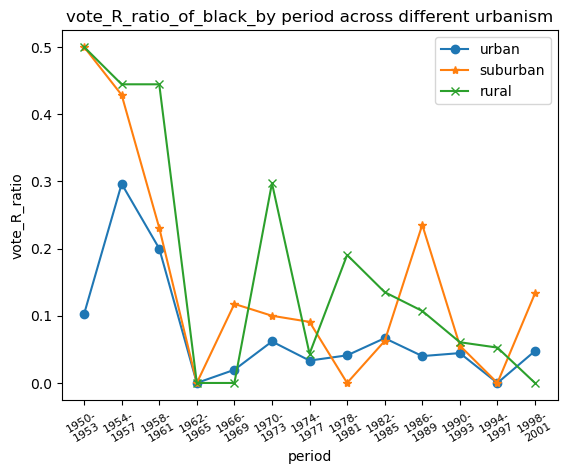

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

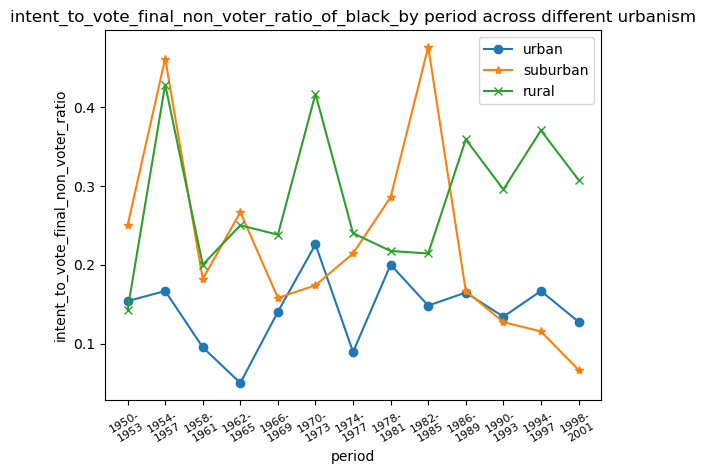

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

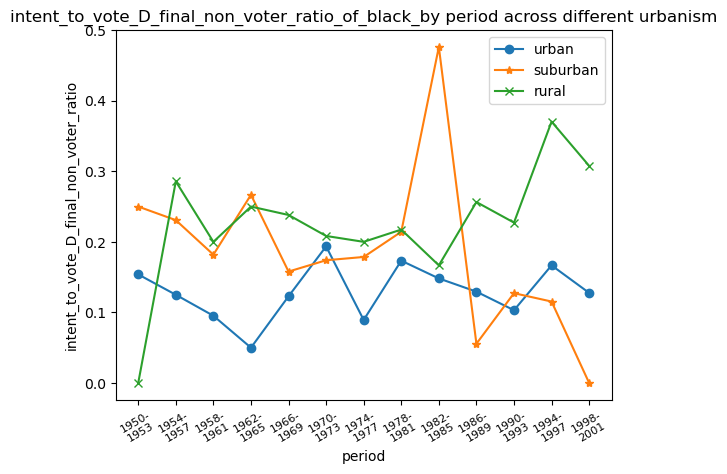

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'intent_to_vote_ratio': 0.7315068493150685, 'intent_not_to_vote_ratio': 0.20821917808219179, 'intent_to_vote_final_non_voter_ratio': 0.149812734082397, 'intent_to_vote_R_final_non_voter_ratio': 0.016229712858926344, 'intent_to_vote_D_final_non_voter_ratio': 0.13358302122347065, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747, 'intent_to_vote_size': 801, 'intent_not_to_vote_size': 228, 'has_intent_feature_size': 1095, 'intent_to_vote_final_non_voter_size': 120, 'intent_to_vote_R_final_non_voter_size': 13, 'intent_to_vote_D_final_non_voter_size': 107}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'intent_to_vote_rati

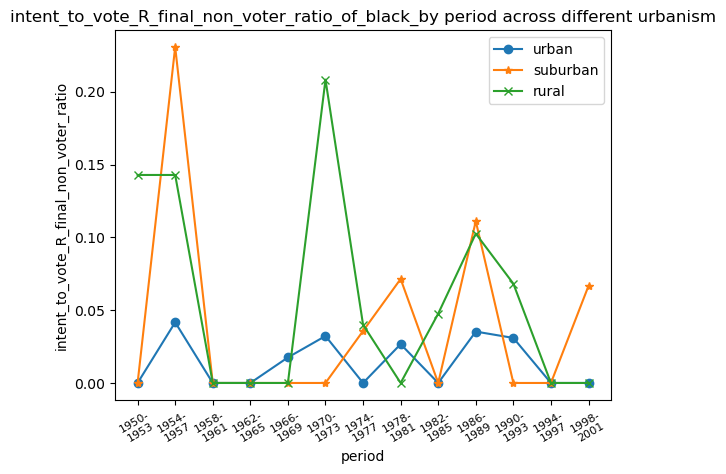

In [99]:
period_list = [(i,i+3) for i in range(1950,2002,4)]
# period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]

plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='voter_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='vote_D_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='vote_R_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='intent_to_vote_final_non_voter_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='intent_to_vote_D_final_non_voter_ratio', period_list = period_list)
plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='intent_to_vote_R_final_non_voter_ratio', period_list = period_list)




([<matplotlib.axis.XTick at 0x7f115c77f370>,
 [Text(0, 0, 'urban'), Text(1, 0, 'suburban'), Text(2, 0, 'rural')])

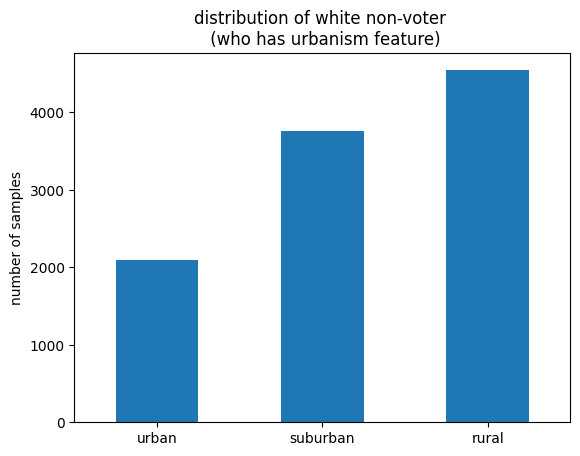

In [43]:
# no_urbanism_group['Year'].value_counts().sort_index().plot(kind='bar',title='white')

non_voter_white = group[group['Voted'] == 1]

# plot the distribution of non-voter white by urbanism
# add x-axis label: 1.0-urban, 2.0-suburban, 3.0-urban
# add y-axis label: number of samples
# add title: white non-voter

dist = non_voter_white['urbanism'].value_counts().sort_index()

import matplotlib.pyplot as plt

# add x-ticks: 1.0-urban, 2.0-suburban, 3.0-rural

dist.plot(kind='bar',title='distribution of white non-voter \n (who has urbanism feature)',ylabel='number of samples')
plt.xticks([0,1,2],['urban','suburban','rural'],rotation=0)





In [33]:
non_voter_white['urbanism'].value_counts().sort_index()

1.0    2089
2.0    3757
3.0    4540
Name: urbanism, dtype: int64

In [34]:
len(non_voter_white)

13037

### problen of black group analysis: 
1- "urbanism" seems be a old feature (only use till 2000) (check with black_with_urbanism_group.['Year'].value_counts())

2- Many voters's "vote_party" variable are missing  


In [12]:

# get the black group and subgroup of Urban, Suburban and Rural
black_group = data_new[data_new['Race7'] == 2]
black_with_urbanism_group = black_group[black_group['urbanism'].notnull()]
black_no_urbanism_group = black_group[black_group['urbanism'].isnull()]

black_urban_group = black_group[black_group['urbanism']==1]
black_suburban_group = black_group[black_group['urbanism']==2]
black_rural_group = black_group[black_group['urbanism']==3]


# black_ratio_dict =  stat_ratio_by_period(black_group, 'black_group')
# black_with_urbanism_dict =  stat_ratio_by_period(black_with_urbanism_group, 'black_with_urbanism_group')        
# black_no_urbanism_dict =  stat_ratio_by_period(black_no_urbanism_group, 'black_no_urbanism_group')        

# black_urban_ratio_dict =  stat_ratio_by_period(black_urban_group, 'black_urban_group')
# black_suburban_ratio_dict =  stat_ratio_by_period(black_suburban_group, 'black_suburban_group')
# black_rural_ratio_dict =  stat_ratio_by_period(black_rural_group, 'black_rural_group')


black_ratio_dict =  stat_ratio(black_group, 'black_group', print_flag=True)
black_with_urbanism_dict =  stat_ratio(black_with_urbanism_group, 'black_with_urbanism_group', print_flag=True)        
black_no_urbanism_dict =  stat_ratio(black_no_urbanism_group, 'black_no_urbanism_group',    print_flag=True)        

black_urban_ratio_dict =  stat_ratio(black_urban_group, 'black_urban_group', print_flag=True)
black_suburban_ratio_dict =  stat_ratio(black_suburban_group, 'black_suburban_group',   print_flag=True)
black_rural_ratio_dict =  stat_ratio(black_rural_group, 'black_rural_group',    print_flag=True)

1.0    706
2.0     41
Name: Voted_D_R, dtype: int64

In [21]:
"""Blacks in urban America are more likely to vote and vote for the Democratic candidates than are Blacks in rural America."""
def binom_test(group_dict, sub_group_dict):
    # apply the binomial test to test the difference between given groups

def chi2_test()


,Year,South,region,racial_composition_nbhood,racial_composition_gradeSchool,racial_composition_juniorHigh,racial_composition_highSchool,racial_composition_shops,racial_composition_friends,length_residence_home,...,interest_pubAffair,therm_DemParty,therm_RepParty,Voted_party,Voted_D_R,Family_income,occupation,occupation14,occupation71,home_ownership
10,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
37,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
44,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
60,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,3.0,NaN,NaN,NaN,NaN
62,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68194,2020.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0
68197,2020.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,60.0,15.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0
68201,2020.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,60.0,15.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0
68210,2020.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0


In [ ]:
def binom_test(group_dict, sub_group_dict):
    # apply the binomial test to test the difference between given groups

In [8]:

import numpy as np
import scipy.stats as stats

# 示例数据生成
np.random.seed(42) # 确保结果可复现

# 假设我们有两个地区的黑人选民投票数据，urban（城市）和 rural（农村）
# 假设城市有100个样本，农村有100个样本
# 假定城市中有75人投票给了民主党，农村中有60人投票给了民主党

# 投票数据模拟
urban_votes = np.random.binomial(1, 0.75, 100) # 城市，75%投给民主党
rural_votes = np.random.binomial(1, 0.60, 100) # 农村，60%投给民主党

# 二项检验 - 检验城市地区投给民主党的比例是否显著不同于0.75
binom_test_urban = stats.binom_test(urban_votes.sum(), n=100, p=0.75, alternative='two-sided')

# 卡方检验 - 比较城市和农村投票给民主党的比例差异
# 构建列联表
contingency_table = np.array([[urban_votes.sum(), 100 - urban_votes.sum()],
                              [rural_votes.sum(), 100 - rural_votes.sum()]])

chi2_test = stats.chi2_contingency(contingency_table)[:2] # 取卡方统计量和p值

binom_test_urban, chi2_test


(0.908200308233164, (5.834757834757835, 0.015712572311655546))

### ve